In [1]:
!python --version

Python 3.9.12


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
import pickle
import mlflow
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [3]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi")

<Experiment: artifact_location='/workspaces/MLOps-Zoomcamp/2. Module 2 - Experiment Tracking/mlruns/1', creation_time=1748193104587, experiment_id='1', last_update_time=1748193104587, lifecycle_stage='active', name='nyc-taxi', tags={}>

In [4]:
def read_data_frame(file):
    df = pd.read_parquet(file)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    numerical = ['trip_distance']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [5]:
df_train = read_data_frame('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')
df_val = read_data_frame('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet')

In [6]:
df_train

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.50,...,0.5,0.00,0.00,None,0.3,6.80,2.0,1.0,0.00,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.00,...,0.5,2.81,0.00,None,0.3,16.86,1.0,1.0,2.75,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.00,...,0.5,1.00,0.00,None,0.3,8.30,1.0,1.0,0.00,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.00,...,0.5,0.00,0.00,None,0.3,9.30,2.0,1.0,0.00,7.083333
7,2,2021-01-01 00:26:31,2021-01-01 00:28:50,N,1.0,75,75,6.0,0.45,3.50,...,0.5,0.96,0.00,None,0.3,5.76,1.0,1.0,0.00,2.316667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76513,2,2021-01-31 21:38:00,2021-01-31 22:16:00,None,NaN,81,90,NaN,17.63,56.23,...,0.0,0.00,6.12,None,0.3,65.40,NaN,NaN,NaN,38.000000
76514,2,2021-01-31 22:43:00,2021-01-31 23:21:00,None,NaN,35,213,NaN,18.36,46.66,...,0.0,12.20,6.12,None,0.3,65.28,NaN,NaN,NaN,38.000000
76515,2,2021-01-31 22:16:00,2021-01-31 22:27:00,None,NaN,74,69,NaN,2.50,18.95,...,0.0,0.00,0.00,None,0.3,22.00,NaN,NaN,NaN,11.000000
76516,2,2021-01-31 23:10:00,2021-01-31 23:37:00,None,NaN,168,215,NaN,14.48,48.87,...,0.0,0.00,6.12,None,0.3,58.04,NaN,NaN,NaN,27.000000


/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='duration', ylabel='Density'>

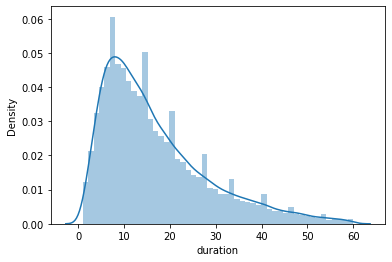

In [7]:
sns.distplot(df_train.duration)

In [8]:
df_train.duration

0         3.933333
1         8.750000
2         5.966667
3         7.083333
7         2.316667
           ...    
76513    38.000000
76514    38.000000
76515    11.000000
76516    27.000000
76517    10.000000
Name: duration, Length: 73908, dtype: float64

In [9]:
df_train.duration.describe()

count    73908.000000
mean        16.852578
std         11.563163
min          1.000000
25%          8.050000
50%         14.000000
75%         22.633333
max         60.000000
Name: duration, dtype: float64

In [10]:
df_train.duration.describe(percentiles=[0.95, 0.98, 0.99])

count    73908.000000
mean        16.852578
std         11.563163
min          1.000000
50%         14.000000
95%         41.000000
98%         48.781000
99%         53.000000
max         60.000000
Name: duration, dtype: float64

In [11]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

train_dicts = df_train[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
x_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df_train[target].values

lr = LinearRegression()
lr.fit(x_train, y_train)

y_pred = lr.predict(x_train)

mean_squared_error(y_train, y_pred, squared=False)

9.775464278878395

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


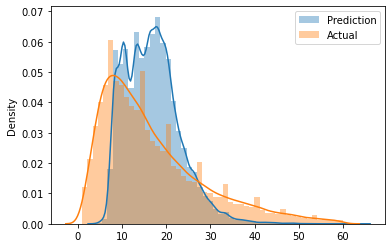

In [12]:
sns.distplot(y_pred, label='Prediction')
sns.distplot(y_train, label='Actual')

plt.legend()

In [13]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [14]:
categorical = ['PU_DO']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
x_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
x_val = dv.transform(val_dicts)

In [15]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [16]:
lr = LinearRegression()
lr.fit(x_train, y_train)

y_pred = lr.predict(x_val)

mean_squared_error(y_val, y_pred, squared=False)

7.4793657829373155

In [17]:
with open('Models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [18]:
with mlflow.start_run():
    
    mlflow.set_tag("developer", "Marc")
    mlflow.log_param("train-data-path", "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet")
    mlflow.log_param("valid-data-path", "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet")
    
    alpha = 0.1
    mlflow.log_param('alpha', alpha)
    
    lr = Lasso(alpha=alpha)
    lr.fit(x_train, y_train)

    y_pred = lr.predict(x_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)
    
    mlflow.log_artifact(local_path="Models/lin_reg.bin", artifact_path="models_pickle")

In [19]:
lr = Ridge()
lr.fit(x_train, y_train)

y_pred = lr.predict(x_val)

mean_squared_error(y_val, y_pred, squared=False)

11.342603943214286

In [20]:
train = xgb.DMatrix(x_train, label=y_train)
valid = xgb.DMatrix(x_val, label=y_val)

In [21]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, "validation")],
            early_stopping_rounds=50
        )
        
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)
    
    return {'loss': rmse, 'status': STATUS_OK}

In [22]:
"""
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0), # Range between exp(-3), and exp(0) == [0.05, 1]
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lamda': hp.loguniform('reg_lamda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)
"""

"\nsearch_space = {\n    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),\n    'learning_rate': hp.loguniform('learning_rate', -3, 0), # Range between exp(-3), and exp(0) == [0.05, 1]\n    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),\n    'reg_lamda': hp.loguniform('reg_lamda', -6, -1),\n    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),\n    'objective': 'reg:linear',\n    'seed': 42\n}\n\nbest_result = fmin(\n    fn=objective,\n    space=search_space,\n    algo=tpe.suggest,\n    max_evals=50,\n    trials=Trials()\n)\n"

In [23]:
"""
params = {
    'max_depth': 17,
    'learning_rate': 0.20472169880371677,
    'reg_alpha': 0.28567896734700793,
    'reg_lamda': 0.004264404814393109,
    'min_child_weight': 1.2402611720043835,
    'objective': 'reg:linear',
    'seed': 42
}

mlflow.xgboost.autolog()

booster = xgb.train(
    params=params,
    dtrain=train,
    num_boost_round=1000,
    evals=[(valid, "validation")],
    early_stopping_rounds=50
)
"""

'\nparams = {\n    \'max_depth\': 17,\n    \'learning_rate\': 0.20472169880371677,\n    \'reg_alpha\': 0.28567896734700793,\n    \'reg_lamda\': 0.004264404814393109,\n    \'min_child_weight\': 1.2402611720043835,\n    \'objective\': \'reg:linear\',\n    \'seed\': 42\n}\n\nmlflow.xgboost.autolog()\n\nbooster = xgb.train(\n    params=params,\n    dtrain=train,\n    num_boost_round=1000,\n    evals=[(valid, "validation")],\n    early_stopping_rounds=50\n)\n'

In [24]:
mlflow.xgboost.autolog(disable=True)

In [25]:
with mlflow.start_run():
    best_params = {
        'max_depth': 17,
        'learning_rate': 0.20472169880371677,
        'reg_alpha': 0.28567896734700793,
        'reg_lamda': 0.004264404814393109,
        'min_child_weight': 1.2402611720043835,
        'objective': 'reg:linear',
        'seed': 42
    }

    mlflow.log_params(best_params)

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, "validation")],
        early_stopping_rounds=50
    )
    
    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)
    
    with open('Models/preprocessor.b', 'wb') as f_out:
        pickle.dump((dv, lr), f_out)
    
    mlflow.log_artifact("Models/preprocessor.b", artifact_path="preprocessor")
    
    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [06:34:17] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [06:34:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "reg_lamda" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:10.61602
[1]	validation-rmse:9.44614
[2]	validation-rmse:8.60401
[3]	validation-rmse:8.01180
[4]	validation-rmse:7.59760
[5]	validation-rmse:7.30899
[6]	validation-rmse:7.11229
[7]	validation-rmse:6.97328
[8]	validation-rmse:6.87539
[9]	validation-rmse:6.80545
[10]	validation-rmse:6.75522
[11]	validation-rmse:6.71690
[12]	validation-rmse:6.68955
[13]	validation-rmse:6.66975
[14]	validation-rmse:6.65156
[15]	validation-rmse:6.63964
[16]	validation-rmse:6.62926
[17]	validation-rmse:6.62080
[18]	validation-rmse:6.61495
[19]	validation-rmse:6.61072
[20]	validation-rmse:6.60481
[21]	validation-rmse:6.60252
[22]	validation-rmse:6.60168
[23]	validation-rmse:6.59882
[24]	validation-rmse:6.59752
[25]	validation-rmse:6.59541
[26]	validation-rmse:6.59393
[27]	validation-rmse:6.59220
[28]	validation-rmse:6.59095
[29]	validation-rmse:6.58905
[30]	validation-rmse:6.58806
[31]	validation-rmse:6.58584
[32]	validation-rmse:6.58418
[33]	validation-rmse:6.58340
[34]	validation-rmse:6.

[277]	validation-rmse:6.42322
[278]	validation-rmse:6.42295
[279]	validation-rmse:6.42255
[280]	validation-rmse:6.42253
[281]	validation-rmse:6.42220
[282]	validation-rmse:6.42195
[283]	validation-rmse:6.42103
[284]	validation-rmse:6.42087
[285]	validation-rmse:6.42055
[286]	validation-rmse:6.42018
[287]	validation-rmse:6.42010
[288]	validation-rmse:6.41956
[289]	validation-rmse:6.41967
[290]	validation-rmse:6.41940
[291]	validation-rmse:6.41932
[292]	validation-rmse:6.41872
[293]	validation-rmse:6.41845
[294]	validation-rmse:6.41777
[295]	validation-rmse:6.41740
[296]	validation-rmse:6.41669
[297]	validation-rmse:6.41646
[298]	validation-rmse:6.41590
[299]	validation-rmse:6.41582
[300]	validation-rmse:6.41587
[301]	validation-rmse:6.41526
[302]	validation-rmse:6.41539
[303]	validation-rmse:6.41506
[304]	validation-rmse:6.41462
[305]	validation-rmse:6.41408
[306]	validation-rmse:6.41390
[307]	validation-rmse:6.41342
[308]	validation-rmse:6.41331
[309]	validation-rmse:6.41296
[310]	vali

[551]	validation-rmse:6.35970
[552]	validation-rmse:6.35961
[553]	validation-rmse:6.35937
[554]	validation-rmse:6.35911
[555]	validation-rmse:6.35927
[556]	validation-rmse:6.35911
[557]	validation-rmse:6.35909
[558]	validation-rmse:6.35882
[559]	validation-rmse:6.35876
[560]	validation-rmse:6.35863
[561]	validation-rmse:6.35848
[562]	validation-rmse:6.35804
[563]	validation-rmse:6.35799
[564]	validation-rmse:6.35778
[565]	validation-rmse:6.35792
[566]	validation-rmse:6.35780
[567]	validation-rmse:6.35744
[568]	validation-rmse:6.35709
[569]	validation-rmse:6.35697
[570]	validation-rmse:6.35684
[571]	validation-rmse:6.35673
[572]	validation-rmse:6.35664
[573]	validation-rmse:6.35604
[574]	validation-rmse:6.35617
[575]	validation-rmse:6.35598
[576]	validation-rmse:6.35600
[577]	validation-rmse:6.35580
[578]	validation-rmse:6.35558
[579]	validation-rmse:6.35544
[580]	validation-rmse:6.35542
[581]	validation-rmse:6.35513
[582]	validation-rmse:6.35466
[583]	validation-rmse:6.35440
[584]	vali

[825]	validation-rmse:6.32761
[826]	validation-rmse:6.32757
[827]	validation-rmse:6.32753
[828]	validation-rmse:6.32729
[829]	validation-rmse:6.32708
[830]	validation-rmse:6.32701
[831]	validation-rmse:6.32718
[832]	validation-rmse:6.32718
[833]	validation-rmse:6.32703
[834]	validation-rmse:6.32693
[835]	validation-rmse:6.32696
[836]	validation-rmse:6.32687
[837]	validation-rmse:6.32657
[838]	validation-rmse:6.32667
[839]	validation-rmse:6.32658
[840]	validation-rmse:6.32663
[841]	validation-rmse:6.32633
[842]	validation-rmse:6.32627
[843]	validation-rmse:6.32621
[844]	validation-rmse:6.32629
[845]	validation-rmse:6.32614
[846]	validation-rmse:6.32603
[847]	validation-rmse:6.32589
[848]	validation-rmse:6.32590
[849]	validation-rmse:6.32582
[850]	validation-rmse:6.32576
[851]	validation-rmse:6.32555
[852]	validation-rmse:6.32550
[853]	validation-rmse:6.32538
[854]	validation-rmse:6.32508
[855]	validation-rmse:6.32502
[856]	validation-rmse:6.32490
[857]	validation-rmse:6.32497
[858]	vali

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [06:36:05] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/05/26 06:36:08 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpia6yncus/model, flavor: xgboost). Fall back to return ['xgboost==2.1.4']. Set logging level to DEBUG to see the full traceback. 
2025/05/26 06:36:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [26]:
logged_model = 'runs:/04acdf5182b5406284accc98b4ff5708/models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: models_mlflow
  flavor: mlflow.xgboost
  run_id: 04acdf5182b5406284accc98b4ff5708

In [27]:
xgboost_model = mlflow.xgboost.load_model(logged_model)

xgboost_model

In [28]:
y_pred = xgboost_model.predict(valid)

y_pred[:10]

array([14.422148 ,  7.2832036, 15.511797 , 24.380302 ,  9.07571  ,
       17.124989 , 11.194462 ,  8.594795 ,  8.980683 , 18.265078 ],
      dtype=float32)